In [ ]:
from datetime import datetime
start_time = datetime.now()
print(f"Start time: {start_time}")

# The folder 

In [2]:
THEFOLDER = "C:\\Users\\smdur\\OneDrive\\Desktop\\GlobalPCL11"

# Tile Conus PCL

In [ ]:
import os
from itertools import product
import rasterio as rio
from rasterio import windows

in_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\PCLCONUS\\Input\\PCL\\"
input_filename = 'pcl_west_wgs.tif'

out_path = f"{THEFOLDER}\\PCLTILES\\"
output_filename = 'pcltile_{}-{}.tif'

widthtile = 5000
heighttile = 5000

def get_tiles(ds, width=widthtile, height=heighttile):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

os.makedirs(out_path, exist_ok=True)

with rio.open(os.path.join(in_path, input_filename)) as inds:
    tile_width, tile_height = widthtile, heighttile
    nodata = inds.nodata  
    meta = inds.meta.copy()
    for window, transform in get_tiles(inds):
        print(window)
        data = inds.read(window=window)
        if nodata is not None and not (data == nodata).all():
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
            with rio.open(outpath, 'w', **meta) as outds:
                outds.write(data)


# Data Download - one tile

In [4]:
### for DEM
import rioxarray
from pystac_client import Client
import planetary_computer
from concurrent.futures import ThreadPoolExecutor
import rioxarray
import matplotlib.pyplot as plt
import os
import glob
import subprocess
from osgeo import gdal, ogr, osr

TILENUMBER = '75000-35000'

# Path to the GeoTIFF file (one from above)
tif_path = f"{THEFOLDER}\\PCLTILES\\pcltile_{TILENUMBER}.tif"

# Directory for TIFF files
tif_dir = f"{THEFOLDER}\\TIFFOUTPUT\\"
os.makedirs(tif_dir, exist_ok=True)

# Read the GeoTIFF file using rioxarray
tif_data = rioxarray.open_rasterio(tif_path)

# Get the spatial extent of the GeoTIFF
min_lon, min_lat, max_lon, max_lat = tif_data.rio.bounds()
bbox_of_interest = [min_lon, min_lat, max_lon, max_lat]  # Replace with your actual bounding box coordinates

# Create a catalog search for the specified collection and bounding box
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(collections=["cop-dem-glo-30"], bbox=bbox_of_interest)
items = list(search.get_items())
print(f"Returned {len(items)} items")

def process_item(item, idx):
    signed_asset = planetary_computer.sign(item.assets["data"])
    data = (
        rioxarray.open_rasterio(signed_asset.href)
        .squeeze()
        .drop("band")
    )
    data.rio.write_crs("EPSG:4326", inplace=True)

    output_tif_path = os.path.join(tif_dir, f"output_dataDEM_{idx}.tif")
    data.rio.to_raster(output_tif_path)

with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on your CPU
    for i, item in enumerate(items):  # Change this line to process only the last three items
        executor.submit(process_item, item, len(items) - 3 + i)  # Adjust index for correct labeling

output_tif = os.path.join(tif_dir, f"outputtile_DEM_{TILENUMBER}.tif")

# Get the list of TIFF files
tifs = glob.glob(os.path.join(tif_dir, "*.tif"))

# Prepare the gdal_merge command
merge_command_hag = [
    "python",
    "C:\\Users\\smdur\\anaconda3\\envs\\globalpcl\\Scripts\\gdal_merge.py",
    "--config", "CHECK_DISK_FREE_SPACE", "FALSE",
    "-o", output_tif,
    "-n", "-9999",
    "-a_nodata", "-9999"
] + tifs

# Run the gdal_merge command and capture the output
process_hag = subprocess.run(merge_command_hag, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Open the source (lidarHAG) and target (pcl) datasets
src_ds = gdal.Open(output_tif, gdal.GA_ReadOnly)
target_ds = gdal.Open(tif_path, gdal.GA_ReadOnly)

# Get the Geotransform and Projection from the target dataset
target_transform = target_ds.GetGeoTransform()
target_projection = target_ds.GetProjection()
target_cols = target_ds.RasterXSize
target_rows = target_ds.RasterYSize

# Create a new dataset for output with the same size and projection as the target
driver = gdal.GetDriverByName('GTiff')
output_path = os.path.join(tif_dir, f"output_resampled_dataDEM_{TILENUMBER}.tif")

out_ds = driver.Create(output_path, target_cols, target_rows, 1, src_ds.GetRasterBand(1).DataType)
out_ds.SetGeoTransform(target_transform)
out_ds.SetProjection(target_projection)

# Perform the resampling
gdal.ReprojectImage(src_ds, out_ds, src_ds.GetProjection(), target_projection, gdal.GRA_Bilinear)

src_ds = None
target_ds = None
out_ds = None

os.remove(output_tif)

if process_hag.returncode != 0:
    print(process_hag.stderr)
else:
    for tif in tifs:
        try:
            os.remove(tif)
        except Exception as e:
            print(f"Failed to delete {tif}: {e}")

print("Resampling completed. Output saved at:", output_path)

Returned 4 items
Resampling completed. Output saved at: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\TIFFOUTPUT\output_resampled_dataDEM_75000-35000.tif


In [5]:
### for LIDAR
import os
import glob
import subprocess
from osgeo import gdal, ogr, osr

lidar_dir = r"C:\Users\smdur\OneDrive\Desktop\GlobalData\LIDAR"

tifs = glob.glob(os.path.join(lidar_dir, "*.tif"))

output_tif = os.path.join(tif_dir, f"outputtile_lidar.tif")

# Prepare the gdal_merge command
merge_command_hag = [
    "python",
    "C:\\Users\\smdur\\anaconda3\\envs\\globalpcl\\Scripts\\gdal_merge.py",
    "--config", "CHECK_DISK_FREE_SPACE", "FALSE",
    "-o", output_tif,
    "-n", "255",
    "-a_nodata", "255"
] + tifs

# Run the gdal_merge command and capture the output
process_hag = subprocess.run(merge_command_hag, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Open the source (lidarHAG) and target (pcl) datasets
src_ds = gdal.Open(output_tif, gdal.GA_ReadOnly)
target_ds = gdal.Open(tif_path, gdal.GA_ReadOnly)

# Get the Geotransform and Projection from the target dataset
target_transform = target_ds.GetGeoTransform()
target_projection = target_ds.GetProjection()
target_cols = target_ds.RasterXSize
target_rows = target_ds.RasterYSize

# Create a new dataset for output with the same size and projection as the target
driver = gdal.GetDriverByName('GTiff')

output_path = os.path.join(tif_dir, f"output_resampled_dataLIDAR_{TILENUMBER}.tif")

out_ds = driver.Create(output_path, target_cols, target_rows, 1, src_ds.GetRasterBand(1).DataType)
out_ds.SetGeoTransform(target_transform)
out_ds.SetProjection(target_projection)

# Perform the resampling
gdal.ReprojectImage(src_ds, out_ds, src_ds.GetProjection(), target_projection, gdal.GRA_Bilinear)

# Close the datasets
src_ds = None
target_ds = None
out_ds = None

os.remove(output_tif)

print("Resampling completed. Output saved at:", output_path)

Resampling completed. Output saved at: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\TIFFOUTPUT\output_resampled_dataLIDAR_75000-35000.tif


In [6]:
# for Rivers
import rioxarray
import osmnx as ox

# Read the GeoTIFF file using rioxarray
dem_data = rioxarray.open_rasterio(tif_path)

# Get the spatial extent of the GeoTIFF
min_lon, min_lat, max_lon, max_lat = dem_data.rio.bounds()

#custom_filter = '["waterway"~"river|streams|canals"]'
custom_filter = '["waterway"~"river"]'

bbox = (max_lat, min_lat, max_lon, min_lon)  
graph = ox.graph_from_bbox(bbox=bbox, custom_filter=custom_filter, simplify=True, retain_all=True, truncate_by_edge=True)

gdf = ox.graph_to_gdfs(graph, nodes=False)

# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

import rasterio
from rasterio.features import rasterize
from rasterio.windows import from_bounds
import numpy as np
import scipy.ndimage

# Define the decay constant
lambda_decay = 0.03  # This value might need adjustment based on your specific use case

# Load the reference TIFF to use for transformations and metadata
with rasterio.open(tif_path) as src:

    min_lon, min_lat, max_lon, max_lat = src.bounds
    
    meta = src.meta.copy()

    # Convert geographic coordinates to pixel coordinates
    window = from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
    transform = rasterio.windows.transform(window, src.transform)

    # Correct the window dimensions to integers
    window_width = int(window.width)
    window_height = int(window.height)

    # Create an empty raster array for the size of the window
    raster = np.zeros((window_height, window_width), dtype=np.uint8)

    # Rasterize directly into the window shape
    shapes = ((geom, 1) for geom in gdf['geometry'])
    burned = rasterize(shapes, out=raster, fill=0, transform=transform, all_touched=True)

    # Compute the Euclidean distance from each cell to the nearest non-zero cell
    distance_grid = scipy.ndimage.distance_transform_edt(burned == 0)

    # Apply exponential decay to the distance grid
    decay_grid = np.exp(-lambda_decay * distance_grid)

    # Prepare metadata for saving the decay grid
    clipped_meta = meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": window_height,
        "width": window_width,
        "transform": transform,
        "dtype": rasterio.float32,
        "count": 1,
        "compress": 'lzw'
    })

    # Save the decay grid to a new TIFF file
    output_path = f'{THEFOLDER}\\exponential_decay_CO_river.tif'
    with rasterio.open(output_path, 'w', **clipped_meta) as dst:
        dst.write(decay_grid.astype(np.float32), 1)

from osgeo import gdal, ogr, osr

# Define the paths to your rasters
#lidarHAG_path = r"C:\Users\smdur\OneDrive\Desktop\GLOBALPCL\Input\exponential_decay_CO_river.tif"
#pcl_path = r"C:\Users\smdur\OneDrive\Desktop\GLOBALPCL\Input\pcl_west_wgs_CO_3.tif"

# Open the source (lidarHAG) and target (pcl) datasets
src_ds = gdal.Open(output_path, gdal.GA_ReadOnly)
target_ds = gdal.Open(tif_path, gdal.GA_ReadOnly)


# Get the Geotransform and Projection from the target dataset
target_transform = target_ds.GetGeoTransform()
target_projection = target_ds.GetProjection()
target_cols = target_ds.RasterXSize
target_rows = target_ds.RasterYSize

# Create a new dataset for output with the same size and projection as the target
driver = gdal.GetDriverByName('GTiff')
output_path_resample = f"{tif_dir}output_resampled_dataRivers_{TILENUMBER}.tif"
out_ds = driver.Create(output_path_resample, target_cols, target_rows, 1, src_ds.GetRasterBand(1).DataType)
out_ds.SetGeoTransform(target_transform)
out_ds.SetProjection(target_projection)

# Perform the resampling
gdal.ReprojectImage(src_ds, out_ds, src_ds.GetProjection(), target_projection, gdal.GRA_Bilinear)

# Close the datasets
src_ds = None
target_ds = None
out_ds = None

print("Resampling completed. Output saved at:", output_path)

# Check if the file exists before trying to delete it
if os.path.exists(output_path):
    try:
        os.remove(output_path)
        print(f"File {output_path} deleted successfully.")
    except Exception as e:
        print(f"Failed to delete {output_path}: {e}")
else:
    print(f"No file found at {output_path}, deletion not required.")


Resampling completed. Output saved at: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\exponential_decay_CO_river.tif
File C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\exponential_decay_CO_river.tif deleted successfully.


In [7]:
# for Roads
import rioxarray
# Path to the GeoTIFF file
#tif_path = r"C:\Users\smdur\OneDrive\Desktop\PCLCONUS\Input\PCLTILES\pcltile_75000-35000.tif"

# Directory for TIFF files
#tif_dir = r'C:\Users\smdur\OneDrive\Desktop\PCLCONUS\Input\scratch\dem'

# Read the GeoTIFF file using rioxarray
extent_data = rioxarray.open_rasterio(tif_path)

# Get the spatial extent of the GeoTIFF
min_lon, min_lat, max_lon, max_lat = extent_data.rio.bounds()

graph = ox.graph_from_bbox(max_lat, min_lat, max_lon, min_lon, network_type='drive', simplify=True)

gdf = ox.graph_to_gdfs(graph, nodes=False)

# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

# Plot the waterway network
# fig, ax = plt.subplots(figsize=(10, 10))
# edges.plot(ax=ax, linewidth=1, edgecolor='blue')
# #plt.title('Waterways in Fort Collins')
# plt.show()


import rasterio
from rasterio.features import rasterize
from rasterio.windows import from_bounds
import numpy as np
import scipy.ndimage

# Define the decay constant
lambda_decay = 0.03  # This value might need adjustment based on your specific use case

# Load the reference TIFF to use for transformations and metadata
with rasterio.open(tif_path) as src:

    min_lon, min_lat, max_lon, max_lat = src.bounds
    
    meta = src.meta.copy()

    # Convert geographic coordinates to pixel coordinates
    window = from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
    transform = rasterio.windows.transform(window, src.transform)

    # Correct the window dimensions to integers
    window_width = int(window.width)
    window_height = int(window.height)

    # Create an empty raster array for the size of the window
    raster = np.zeros((window_height, window_width), dtype=np.uint8)

    # Rasterize directly into the window shape
    shapes = ((geom, 1) for geom in gdf['geometry'])
    burned = rasterize(shapes, out=raster, fill=0, transform=transform, all_touched=True)

    # Compute the Euclidean distance from each cell to the nearest non-zero cell
    distance_grid = scipy.ndimage.distance_transform_edt(burned == 0)

    # Apply exponential decay to the distance grid
    decay_grid = np.exp(-lambda_decay * distance_grid)

    # Prepare metadata for saving the decay grid
    clipped_meta = meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": window_height,
        "width": window_width,
        "transform": transform,
        "dtype": rasterio.float32,
        "count": 1,
        "compress": 'lzw'
    })

    # Save the decay grid to a new TIFF file
    output_path = f'{THEFOLDER}exponential_decay_CO_roads.tif'
    with rasterio.open(output_path, 'w', **clipped_meta) as dst:
        dst.write(decay_grid.astype(np.float32), 1)

from osgeo import gdal, ogr, osr

# Define the paths to your rasters
#lidarHAG_path = r"C:\Users\smdur\OneDrive\Desktop\GLOBALPCL\Input\exponential_decay_CO_river.tif"
#pcl_path = r"C:\Users\smdur\OneDrive\Desktop\GLOBALPCL\Input\pcl_west_wgs_CO_3.tif"

# Open the source (lidarHAG) and target (pcl) datasets
src_ds = gdal.Open(output_path, gdal.GA_ReadOnly)
target_ds = gdal.Open(tif_path, gdal.GA_ReadOnly)


# Get the Geotransform and Projection from the target dataset
target_transform = target_ds.GetGeoTransform()
target_projection = target_ds.GetProjection()
target_cols = target_ds.RasterXSize
target_rows = target_ds.RasterYSize

# Create a new dataset for output with the same size and projection as the target
driver = gdal.GetDriverByName('GTiff')
output_path_resample = f"{tif_dir}\\output_resampled_dataRoads_{TILENUMBER}.tif"
out_ds = driver.Create(output_path_resample, target_cols, target_rows, 1, src_ds.GetRasterBand(1).DataType)
out_ds.SetGeoTransform(target_transform)
out_ds.SetProjection(target_projection)

# Perform the resampling
gdal.ReprojectImage(src_ds, out_ds, src_ds.GetProjection(), target_projection, gdal.GRA_Bilinear)

# Close the datasets
src_ds = None
target_ds = None
out_ds = None

print("Resampling completed. Output saved at:", output_path)

# Check if the file exists before trying to delete it
if os.path.exists(output_path):
    try:
        os.remove(output_path)
        print(f"File {output_path} deleted successfully.")
    except Exception as e:
        print(f"Failed to delete {output_path}: {e}")
else:
    print(f"No file found at {output_path}, deletion not required.")


Resampling completed. Output saved at: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11exponential_decay_CO_roads.tif
File C:\Users\smdur\OneDrive\Desktop\GlobalPCL11exponential_decay_CO_roads.tif deleted successfully.


# Generate Random Points

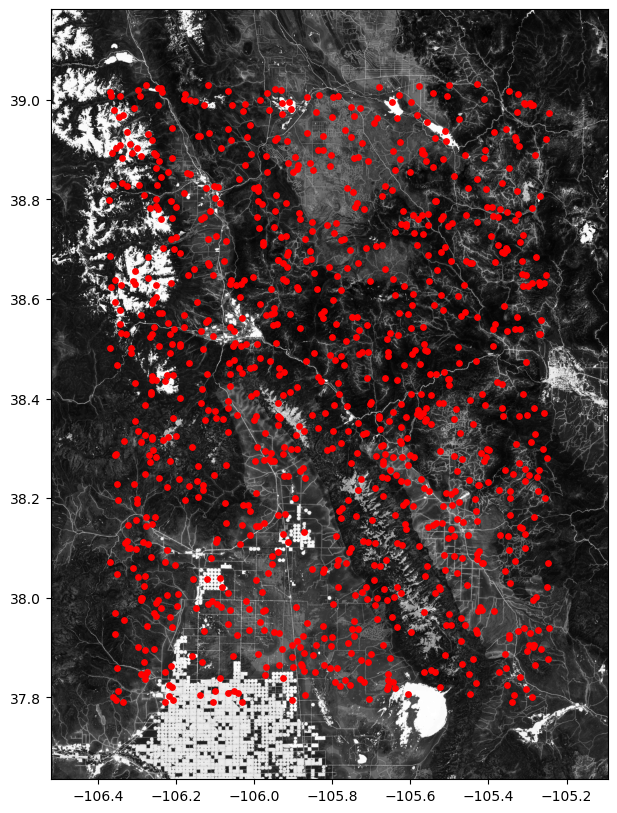

In [7]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import box, Point
from geopandas import GeoDataFrame
import numpy as np
tif_path = r"C:\Users\smdur\OneDrive\Desktop\GlobalPCL23\PCLTILES\pcltile_75000-40000.tif"
# Load the GeoTIFF file
with rasterio.open(tif_path) as src:
    bounds = src.bounds
    crs = src.crs
    img = src.read(1)  # Read the first band

# Create a box from the bounds
rect = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

# Apply a negative buffer to contract the boundary of the rectangle
buffered_rect = rect.buffer(-0.15)  # Adjust buffer size as needed

# Generate random points within the buffered rectangle
def generate_random_points(geometry, num_points):
    points = []
    min_x, min_y, max_x, max_y = geometry.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if random_point.within(geometry):
            points.append(random_point)
    return points

random_points = generate_random_points(buffered_rect, 1000)

# Convert these points to a GeoDataFrame
gdf_points = GeoDataFrame(geometry=random_points, crs=crs)

# Convert points GeoDataFrame to the same CRS as the raster for accurate overlay
gdf_points = gdf_points.to_crs(crs)

# Convert geometries from the CRS to WGS84 for latitude and longitude
gdf_points_wgs84 = gdf_points.to_crs(epsg=4326)

# Extract the latitude and longitude
lat_long = gdf_points_wgs84.geometry.apply(lambda geom: (geom.y, geom.x)).tolist()

# Plotting the raster and the points
fig, ax = plt.subplots(figsize=(10, 10))
show(img, ax=ax, transform=src.transform, cmap='gray')  # Show the raster
gdf_points.plot(ax=ax, color='red', markersize=15)  # Plot the points

#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')

#plt.title('Random Points on Raster')
#output_path = r'C:\Users\smdur\OneDrive\Desktop\PCLCONUS\figures\random_points_plot.png'
plt.savefig(output_path, dpi=300)  # Save the plot with a resolution of 300 DPI
plt.show()

# Create a training chip dataset using those random points

In [20]:
tif_dir

'C:\\Users\\smdur\\OneDrive\\Desktop\\GlobalPCL11\\TIFFOUTPUT\\'

In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np

# Paths to the raster files
resampled_lidar_path = f"{tif_dir}output_resampled_dataLIDAR.tif"
resampled_dem_path = f"{tif_dir}output_resampled_dataDEM.tif"
resampled_rivers_path = f"{tif_dir}output_resampled_dataRivers.tif"
resampled_roads_path = f"{tif_dir}output_resampled_dataRoads.tif"
#PCL_path = r"C:\Users\smdur\OneDrive\Desktop\PCLCONUS\Input\PCLTILES\pcltile_75000-35000.tif"

chip_size = 128  
#chip_size = 256


# Create the base directory for training chips if it does not exist
training_chips_dir = os.path.join(THEFOLDER, "trainingchips")
os.makedirs(training_chips_dir, exist_ok=True)


for i, (lat, lon) in enumerate(lat_long):
    try:
        paths = [resampled_lidar_path, resampled_dem_path, resampled_rivers_path, resampled_roads_path, tif_path]
        labels = ['lidar', 'dem', 'rivers', 'roads', 'pcllabels']
        
        for path, label in zip(paths, labels):
            with rasterio.open(path) as src:
                # Convert the geographic coordinates to pixel coordinates
                col, row = src.index(lon, lat)
                
                # Calculate the window
                window = Window(col - chip_size // 2, row - chip_size // 2, chip_size, chip_size)
                
                # Read the data within the window
                chip_data = src.read(1, window=window)
                
                # Prepare metadata for the chip raster
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": chip_size,
                    "width": chip_size,
                    "transform": src.window_transform(window)
                })

                # Save the chip data to a new file
                #chip_output_path = f"C:\\Users\\smdur\\OneDrive\\Desktop\\GlobalPCL\\trainingchips\\{label}\\{label.upper()}_Chip_{i}.tif"
                chip_output_dir = os.path.join(training_chips_dir, label)
                os.makedirs(chip_output_dir, exist_ok=True)
                
                # Define the chip output path
                chip_output_path = os.path.join(chip_output_dir, f"{label.upper()}_Chip_{TILENUMBER}_{i}.tif")

                # Check if the chip data is valid before saving
                if chip_data.shape == (chip_size, chip_size) and np.any(chip_data != src.nodata):
                    with rasterio.open(chip_output_path, "w", **out_meta) as dest:
                        dest.write(chip_data, 1)
                    #print(f"{label.capitalize()} chip {i} created and saved to: {chip_output_path}")
                else:
                    print(f"Skipping {label} chip {i} because it is not properly shaped or is filled with nodata.")

    except Exception as e:
        print(f"An error occurred while processing chip {i}: {e}")


# load chips and normalize

In [14]:
import os
import rasterio
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
training_chips_dir = r"C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\trainingchips"
# Paths to datasets
featurepath1 = os.path.join(training_chips_dir, "lidar")
featurepath2 = os.path.join(training_chips_dir, "dem")
featurepath3 = os.path.join(training_chips_dir, "roads")
featurepath4 = os.path.join(training_chips_dir, "rivers")
labelspath = os.path.join(training_chips_dir, "pcllabels")

# Function to load GeoTIFF images as numpy arrays
def load_geotiff(path):
    with rasterio.open(path) as src:
        return src.read(1)

# Load datasets
hag_images = [load_geotiff(os.path.join(featurepath1, f)) for f in os.listdir(featurepath1) if f.endswith('.tif')]
dem_images = [load_geotiff(os.path.join(featurepath2, f)) for f in os.listdir(featurepath2) if f.endswith('.tif')]
roads_images = [load_geotiff(os.path.join(featurepath3, f)) for f in os.listdir(featurepath3) if f.endswith('.tif')]
rivers_images = [load_geotiff(os.path.join(featurepath4, f)) for f in os.listdir(featurepath4) if f.endswith('.tif')]
label_images = [load_geotiff(os.path.join(labelspath, f)) for f in os.listdir(labelspath) if f.endswith('.tif')]

# Convert lists to numpy arrays
hag_images = np.array(hag_images).astype('float32')
dem_images = np.array(dem_images).astype('float32')
roads_images = np.array(roads_images).astype('float32')
rivers_images = np.array(rivers_images).astype('float32')
label_images = np.array(label_images).astype('float32')

# Normalize images independently
hag_max = hag_images.max()
dem_max = dem_images.max()
roads_max = roads_images.max()
rivers_max = rivers_images.max()

hag_images /= hag_max
dem_images /= dem_max
roads_images /= roads_max
rivers_images /= rivers_max

print(f"HAG max value: {hag_max}")
print(f"DEM max value: {dem_max}")
print(f"Roads max value: {roads_max}")
print(f"Rivers max value: {rivers_max}")

HAG max value: 30.0
DEM max value: 4379.1279296875
Roads max value: 1.0
Rivers max value: 1.0


In [ ]:
import gc
gc.collect()


# Fit a model to the training set

In [ ]:
# Stack features along the last dimension
feature_images = np.stack((hag_images, dem_images, roads_images, rivers_images), axis=-1)

# Free up memory by deleting the original arrays
del hag_images
del dem_images
del roads_images
del rivers_images

# If you want to ensure that the memory is freed immediately
import gc
gc.collect()

# Normalize labels if they range from 0 to 100
label_images /= 100

# Reshape labels for CNN input
label_images = np.expand_dims(label_images, axis=-1)

# Define the CNN model
model = Sequential([
    #Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 4)),
    Conv2D(16, (3, 3), activation='relu', input_shape=(chip_size, chip_size, 4)),

    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dropout(0.5),
    #Dense(128 * 128, activation='sigmoid'),
    #tf.keras.layers.Reshape((128, 128, 1))
    Dense(chip_size * chip_size, activation='sigmoid'),
    tf.keras.layers.Reshape((chip_size, chip_size, 1))
])

# # Define custom weights for each feature
# weights = np.array([1.0, 0.8, 0.5, 0.3])  # Example weights for each feature

# # Create sample weights based on the custom weights
# sample_weights = np.dot(feature_images, weights)

lr = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Compile and train the model with sample weights
model.compile(optimizer=optimizer, loss='mse')
model.fit(feature_images, label_images, batch_size=128, epochs=10, validation_split=0.3)#, sample_weight=sample_weights)


# Save Model

In [8]:
import numpy as np
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Save the model
#model.save(f"C:\\Users\\smdur\\OneDrive\\Desktop\\SavedModels\\cnn_model_{TILENUMBER}")
#tf.keras.backend.clear_session()

model = tf.keras.models.load_model(f"C:\\Users\\smdur\\OneDrive\\Desktop\\SavedModels\\cnn_model_{TILENUMBER}")

# Prep data for inference

In [ ]:
# # this ensures all tiles are widthtile by heighttile
# import os
# from itertools import product
# import rasterio as rio
# from rasterio import windows

# in_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\PCLCONUS\\Input\\scratch\\'
# input_filename1 = 'lidar\\output_resampled_dataLIDAR.tif'
# input_filename2 = 'dem\\output_resampled_dataDEM.tif'
# input_filename3 = 'roads\\output_resampled_dataRoads.tif'
# input_filename4 = 'rivers\\output_resampled_dataRivers.tif'

# out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\PCLCONUS\\Input\\inferencetiles\\hag\\'
# output_filename = 'tile_{}-{}.tif'
# widthtile = 128
# heighttile = 128


# def get_tiles(ds, width=widthtile, height=heighttile):
#     nols, nrows = ds.meta['width'], ds.meta['height']
#     offsets = product(range(0, nols, width), range(0, nrows, height))
#     #offsets = product(range(0, nols, 1000), range(0, nrows, 1000))

#     big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
#     for col_off, row_off in offsets:
#         window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
#         transform = windows.transform(window, ds.transform)
#         yield window, transform




# with rio.open(os.path.join(in_path, input_filename1)) as inds:
#     tile_width, tile_height = widthtile, heighttile
#     nodata = inds.nodata  # Get the NoData value from the dataset
#     meta = inds.meta.copy()

#     for window, transform in get_tiles(inds):
#         if window.width == tile_width and window.height == tile_height:  # Check if the tile dimensions are as expected
#             data = inds.read(window=window)
#             if nodata is not None:
#                 # Modified check for NoData to include tolerance for floating-point rasters
#                 valid_data_mask = (data != nodata)
#             else:
#                 # If NoData value is not set, consider all data as valid
#                 valid_data_mask = (data == data)

#             if valid_data_mask.any():  # Check if there's any valid data within the tile
#                 meta['transform'] = transform
#                 meta['width'], meta['height'] = window.width, window.height
#                 outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
#                 with rio.open(outpath, 'w', **meta) as outds:
#                     outds.write(data)



# out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\PCLCONUS\\Input\\inferencetiles\\dem\\'
# #output_filename = 'tile_{}-{}.tif'
# #widthtile = 128
# #heighttile = 128

# with rio.open(os.path.join(in_path, input_filename2)) as inds:
#     tile_width, tile_height = widthtile, heighttile
#     nodata = inds.nodata  # Get the NoData value from the dataset
#     meta = inds.meta.copy()

#     for window, transform in get_tiles(inds):
#         if window.width == tile_width and window.height == tile_height:  # Check if the tile dimensions are as expected
#             data = inds.read(window=window)
#             if nodata is not None:
#                 # Modified check for NoData to include tolerance for floating-point rasters
#                 valid_data_mask = (data != nodata)
#             else:
#                 # If NoData value is not set, consider all data as valid
#                 valid_data_mask = (data == data)

#             if valid_data_mask.any():  # Check if there's any valid data within the tile
#                 meta['transform'] = transform
#                 meta['width'], meta['height'] = window.width, window.height
#                 outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
#                 with rio.open(outpath, 'w', **meta) as outds:
#                     outds.write(data)

# out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\PCLCONUS\\Input\\inferencetiles\\roads\\'
# #output_filename = 'tile_{}-{}.tif'
# #widthtile = 128
# #heighttile = 128

# with rio.open(os.path.join(in_path, input_filename3)) as inds:
#     tile_width, tile_height = widthtile, heighttile
#     nodata = inds.nodata  # Get the NoData value from the dataset
#     meta = inds.meta.copy()

#     for window, transform in get_tiles(inds):
#         if window.width == tile_width and window.height == tile_height:  # Check if the tile dimensions are as expected
#             data = inds.read(window=window)
#             if nodata is not None:
#                 # Modified check for NoData to include tolerance for floating-point rasters
#                 valid_data_mask = (data != nodata)
#             else:
#                 # If NoData value is not set, consider all data as valid
#                 valid_data_mask = (data == data)

#             if valid_data_mask.any():  # Check if there's any valid data within the tile
#                 meta['transform'] = transform
#                 meta['width'], meta['height'] = window.width, window.height
#                 outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
#                 with rio.open(outpath, 'w', **meta) as outds:
#                     outds.write(data)

# out_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\PCLCONUS\\Input\\inferencetiles\\rivers\\'
# #output_filename = 'tile_{}-{}.tif'
# #widthtile = 128
# #heighttile = 128

# with rio.open(os.path.join(in_path, input_filename4)) as inds:
#     tile_width, tile_height = widthtile, heighttile
#     nodata = inds.nodata  # Get the NoData value from the dataset
#     meta = inds.meta.copy()

#     for window, transform in get_tiles(inds):
#         if window.width == tile_width and window.height == tile_height:  # Check if the tile dimensions are as expected
#             data = inds.read(window=window)
#             if nodata is not None:
#                 # Modified check for NoData to include tolerance for floating-point rasters
#                 valid_data_mask = (data != nodata)
#             else:
#                 # If NoData value is not set, consider all data as valid
#                 valid_data_mask = (data == data)

#             if valid_data_mask.any():  # Check if there's any valid data within the tile
#                 meta['transform'] = transform
#                 meta['width'], meta['height'] = window.width, window.height
#                 outpath = os.path.join(out_path, output_filename.format(int(window.col_off), int(window.row_off)))
#                 with rio.open(outpath, 'w', **meta) as outds:
#                     outds.write(data)

# print("Done")


In [10]:
import os
from itertools import product
import rasterio as rio
from rasterio import windows

# Define the base output path
out_base_path = f"{THEFOLDER}\inferencechips2"
os.makedirs(out_base_path, exist_ok=True)

# Define input files as a dictionary
input_files = {
    'lidar': f'output_resampled_dataLIDAR_{TILENUMBER}.tif',
    'dem': f'output_resampled_dataDEM_{TILENUMBER}.tif',
    'roads': f'output_resampled_dataRoads_{TILENUMBER}.tif',
    'rivers': f'output_resampled_dataRivers_{TILENUMBER}.tif'
}
output_filename = 'tile_{}-{}.tif'
widthtile = chip_size
heighttile = chip_size

def get_tiles(ds, width=widthtile, height=heighttile):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

def process_file(label, input_filepath, output_folder):
    with rio.open(input_filepath) as inds:
        nodata = inds.nodata  # Get the NoData value from the dataset
        meta = inds.meta.copy()
        
        for window, transform in get_tiles(inds):
            if window.width == widthtile and window.height == heighttile:  # Check if the tile dimensions are as expected
                data = inds.read(window=window)
                if nodata is not None:
                    valid_data_mask = (data != nodata)
                else:
                    valid_data_mask = (data == data)
                
                if valid_data_mask.any():  # Check if there's any valid data within the tile
                    meta['transform'] = transform
                    meta['width'], meta['height'] = window.width, window.height
                    outpath = os.path.join(output_folder, output_filename.format(int(window.col_off), int(window.row_off)))
                    with rio.open(outpath, 'w', **meta) as outds:
                        outds.write(data)
    print(f"Processing for {label} completed.")

# Process each file
for label, filename in input_files.items():
    input_filepath = os.path.join(tif_dir, filename)
    output_folder = os.path.join(out_base_path, label)
    os.makedirs(output_folder, exist_ok=True)
    process_file(label, input_filepath, output_folder)

print("Done")


Processing for lidar completed.
Processing for dem completed.
Processing for roads completed.
Processing for rivers completed.
Done


# list of tile names

In [11]:
import os
import re

# Define the directory path
#directory_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\PCLCONUS\\Input\\inferencetiles\\hag'

# Regular expression to extract the identifier part of the filename 'tile_{identifier}.tif'
pattern = re.compile(r'tile_(\d+-\d+)\.tif')

# List all files in the directory
files = os.listdir(output_folder)

# Use a set to avoid duplicate identifiers
identifiers = set()

# Extract identifiers from filenames
for file in files:
    match = pattern.search(file)
    if match:
        identifiers.add(match.group(1))

# Convert the set to a sorted list
identifier_list = sorted(list(identifiers))
print(len(identifier_list))
print("done")


1521
done


In [ ]:
HAG max value: 30.0
DEM max value: 4379.1279296875
Roads max value: 1.0
Rivers max value: 1.0

# Make Inference on those tiles

In [15]:
import os
import rasterio
import numpy as np
import tensorflow as tf

#tilename = '0-0'
# input_hag_path = f"C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\CNNPCLDEMO\\inferencetiles\\hag\\tile_{tilename}.tif"
# input_dem_path = f"C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\CNNPCLDEMO\\inferencetiles\\dem\\tile_{tilename}.tif"
# input_roads_path = f"C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\CNNPCLDEMO\\inferencetiles\\roads\\tile_{tilename}.tif"
# input_rivers_path = f"C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\CNNPCLDEMO\\inferencetiles\\rivers\\tile_{tilename}.tif"

def load_and_preprocess_image(hag_path, dem_path, roads_path, rivers_path):
    with rasterio.open(hag_path) as src:
        hag_image = src.read(1)
    with rasterio.open(dem_path) as src:
        dem_image = src.read(1)
    with rasterio.open(roads_path) as src:
        roads_image = src.read(1)
    with rasterio.open(rivers_path) as src:
        rivers_image = src.read(1)

    # Normalize and stack the images
    hag_image = np.array(hag_image).astype('float32') / hag_max
    dem_image = np.array(dem_image).astype('float32') / dem_max
    roads_image = np.array(roads_image).astype('float32') / roads_max
    rivers_image = np.array(rivers_image).astype('float32') / rivers_max

    # Stack images along the last dimension
    combined_image = np.stack([hag_image, dem_image, roads_image, rivers_image], axis=-1)

    # Add batch dimension
    combined_image = np.expand_dims(combined_image, axis=0)
    return combined_image



for i in range(len(identifier_list)):
    tilename = identifier_list[i]
    #print(tilename)
    #input_hag_path = f"{out_base_path}\\lidar\\tile_{tilename}.tif"
    #input_dem_path = f"{out_base_path}\\dem\\tile_{tilename}.tif"
    #input_roads_path = f"{out_base_path}\\roads\\tile_{tilename}.tif"
    #input_rivers_path = f"{out_base_path}\\tile_{tilename}.tif"

    input_hag_path = os.path.join(out_base_path, "lidar", f"tile_{tilename}.tif")
    input_dem_path = os.path.join(out_base_path, "dem", f"tile_{tilename}.tif")
    input_roads_path = os.path.join(out_base_path, "roads", f"tile_{tilename}.tif")
    input_rivers_path = os.path.join(out_base_path, "rivers", f"tile_{tilename}.tif")


    input_image = load_and_preprocess_image(input_hag_path, input_dem_path, input_roads_path, input_rivers_path)
    predicted_image = model.predict(input_image)
    predicted_image = np.squeeze(predicted_image)
    
    # Debug print to check if all outputs are the same
    #print("Unique values in predicted output:", np.unique(predicted_image))
    
    # Adjust the scaling factor based on how the labels were scaled during training
    predicted_image *= 100
    
    #output_image_path = f"{THEFOLDER}\\predictions\\predicted_tile_{tilename}.tif"
    predictions_folder = os.path.join(THEFOLDER, "predictions2")
    os.makedirs(predictions_folder, exist_ok=True)
    output_image_path = os.path.join(predictions_folder, f"predicted_tile_{tilename}.tif")

    
    with rasterio.open(input_dem_path) as src: 
        profile = src.profile
    
    with rasterio.open(output_image_path, 'w', **profile) as dst:
        dst.write(predicted_image.astype(rasterio.uint8), 1)

print("Done")


1/1 [==============================] - 0s 187ms/step
Done


# MERGE

In [16]:
import os
import glob
import subprocess

# Define the base folder and output paths
#THEFOLDER = r"C:\Users\smdur\OneDrive\Desktop\GlobalPCL"
predictions_folder = os.path.join(THEFOLDER, "predictions2")
output_dir = os.path.join(THEFOLDER, "mergedoutput")

# Create necessary directories if they don't exist
os.makedirs(predictions_folder, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

output_base_name = "predMerged_"  # Base name for output files

# Get a list of TIFF files
tifs = glob.glob(os.path.join(predictions_folder, "*.tif"))

# Define chunk size for processing
chunk_size = 300

# Calculate the number of chunks needed
num_chunks = len(tifs) // chunk_size
if len(tifs) % chunk_size != 0:
    num_chunks += 1  # Add one more chunk for the remaining files

# Loop through the TIFF files in chunks
for chunk_id in range(num_chunks):
    start_idx = chunk_id * chunk_size
    end_idx = min((chunk_id + 1) * chunk_size, len(tifs))
    chunk_tifs = tifs[start_idx:end_idx]
    
    output_tif = os.path.join(output_dir, f"{output_base_name}{chunk_id + 1}.tif")

    merge_command_hag = [
        "python",
        "C:\\Users\\smdur\\anaconda3\\envs\\globalpcl\\Scripts\\gdal_merge.py",
        "--config", "CHECK_DISK_FREE_SPACE", "FALSE",
        "-o", output_tif,
        "-n", "-9999",
        "-a_nodata", "-9999",
    ] + chunk_tifs

    # Run the gdal_merge command for the current chunk
    process_hag = subprocess.run(merge_command_hag, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Check if the command for the current chunk was successful
    if process_hag.returncode != 0:
        # An error occurred, print the error
        print(f"Error occurred while merging TIFF files for chunk {chunk_id + 1}:")
        print(process_hag.stderr)
    else:
        print(f"TIFF files merged successfully for chunk {chunk_id + 1}. Output: {output_tif}")

# Merge all chunks into a final output file
final_output_tif = os.path.join(THEFOLDER, "FINALOUTPUTTILES", f"predMerged_PCL_{TILENUMBER}.tif")
os.makedirs(os.path.dirname(final_output_tif), exist_ok=True)

chunk_tifs = glob.glob(os.path.join(output_dir, "*.tif"))

merge_command_final = [
    "python",
    "C:\\Users\\smdur\\anaconda3\\envs\\globalpcl\\Scripts\\gdal_merge.py",
    "--config", "CHECK_DISK_FREE_SPACE", "FALSE",
    "-o", final_output_tif,
    "-n", "-9999",
    "-a_nodata", "-9999",
] + chunk_tifs

# Run the gdal_merge command for the final merge
process_final = subprocess.run(merge_command_final, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Check if the command for the final merge was successful
if process_final.returncode != 0:
    # An error occurred, print the error
    print("Error occurred while merging final TIFF files:")
    print(process_final.stderr)
else:
    print("Final TIFF files merged successfully.")

# Clean up temporary chunk files
for tif in chunk_tifs:
    try:
        os.remove(tif)
        print(f"Deleted {tif}")
    except Exception as e:
        print(f"Failed to delete {tif}: {e}")

print("Done")


TIFF files merged successfully for chunk 1. Output: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_1.tif
TIFF files merged successfully for chunk 2. Output: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_2.tif
TIFF files merged successfully for chunk 3. Output: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_3.tif
TIFF files merged successfully for chunk 4. Output: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_4.tif
TIFF files merged successfully for chunk 5. Output: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_5.tif
TIFF files merged successfully for chunk 6. Output: C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_6.tif
Final TIFF files merged successfully.
Deleted C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_1.tif
Deleted C:\Users\smdur\OneDrive\Desktop\GlobalPCL11\mergedoutput\predMerged_2.tif
Deleted C:\Users\smdur\OneDrive\Desktop\Gl

In [17]:
import shutil

if os.path.exists(predictions_folder):
    shutil.rmtree(predictions_folder)
os.makedirs(predictions_folder, exist_ok=True)


In [18]:
# Capture the end time
end_time = datetime.now()
print(f"End time: {end_time}")

# Calculate the time difference
time_diff = end_time - start_time
time_diff_minutes = time_diff.total_seconds() / 60
print(f"Time difference: {time_diff_minutes} minutes")

NameError: name 'datetime' is not defined

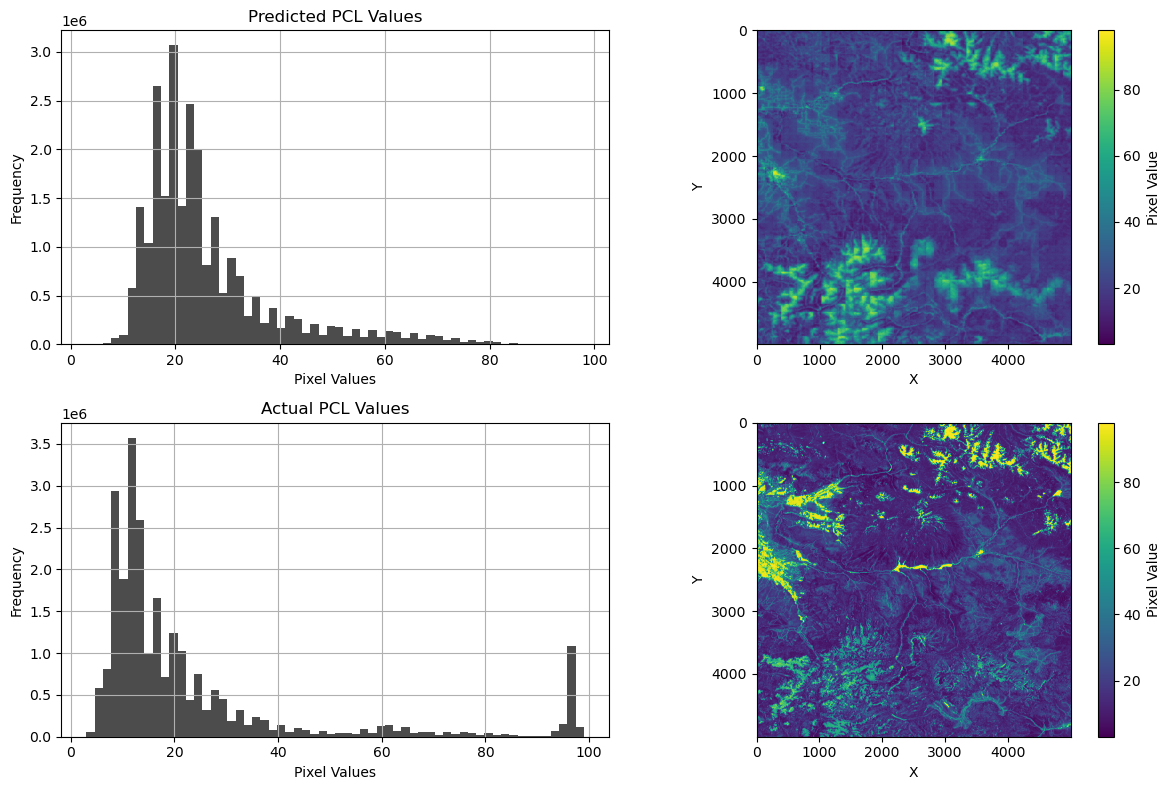

In [9]:
import os
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Path to the first TIFF file
#tif_path1 = r"C:\Users\smdur\OneDrive\Desktop\PCLCONUS\Input\merged\predMerged_PCL.tif"
tif_path1 = r"C:\Users\smdur\OneDrive\Desktop\PCLCONUS\figures\predMerged_PCL_['70000-40000'].tif"
# Path to the second TIFF file
tif_path2 = r"C:\Users\smdur\OneDrive\Desktop\PCLCONUS\figures\pcltile_70000-40000.tif"

# Open the first TIFF file
with rasterio.open(tif_path1) as src1:
    # Read the raster data
    raster_data1 = src1.read(1)
    # Get the colormap for the first raster
    cmap1 = plt.cm.viridis
    
# Open the second TIFF file
with rasterio.open(tif_path2) as src2:
    # Read the raster data
    raster_data2 = src2.read(1)
    # Get the colormap for the second raster
    cmap2 = plt.cm.viridis
    
# Create a figure with subplots for the first raster
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))  # Reduced height to 8 inches

# Plot the histogram for the first raster
axes[0, 0].hist(raster_data1.flatten(), bins=60, color='black', alpha=0.7)
axes[0, 0].set_xlabel('Pixel Values')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Predicted PCL Values')
axes[0, 0].grid(True)

# Plot the first raster image
img1 = axes[0, 1].imshow(raster_data1, cmap=cmap1, norm=Normalize(vmin=raster_data1.min(), vmax=raster_data1.max()))
#axes[0, 1].set_title('Raster 1 Image')
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
fig.colorbar(img1, ax=axes[0, 1], label='Pixel Value')

# Plot the histogram for the second raster
axes[1, 0].hist(raster_data2.flatten(), bins=60, color='black', alpha=0.7)
axes[1, 0].set_xlabel('Pixel Values')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Actual PCL Values')
axes[1, 0].grid(True)

# Plot the second raster image
img2 = axes[1, 1].imshow(raster_data2, cmap=cmap2, norm=Normalize(vmin=raster_data1.min(), vmax=raster_data1.max()))
#axes[1, 1].set_title('Raster 2 Image')
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
fig.colorbar(img2, ax=axes[1, 1], label='Pixel Value')

# Adjust layout and show the plot
plt.tight_layout()

plt.savefig(r'C:\Users\smdur\OneDrive\Desktop\PCLCONUS\figures\modelpred1.png')

plt.show()
